In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_kaggle_origin(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = BatchNormalization()(input_layer)
    for i in range(conv_num):
        for j in range(2):
            x = Conv1D(8*(2 ** i), (3),padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = MaxPooling1D((2), padding='same')(x)

    x = Conv1D(1024, (1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(output_size, activation = 'softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [9]:
for i in range(5, 10):
    model = build_1d_cnn_kaggle_origin(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 1)          4         
_________________________________________________________________
conv1d (Conv1D)              (None, 16000, 8)          32        
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 8)          32        
_________________________________________________________________
activation (Activation)      (None, 16000, 8)          0         
_________________________________________________________________
max_pooling1d (MaxPoo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 1)          4         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 16000, 8)          32        
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 8)          32        
_________________________________________________________________
activation_22 (Activation)   (None, 16000, 8)          0         
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 8000, 8)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 8000, 8)           200       
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
batch_normalization_v1_39 (B (None, 16000, 1)          4         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 16000, 8)          32        
_________________________________________________________________
batch_normalization_v1_40 (B (None, 16000, 8)          32        
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 8)          0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 8000, 8)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 8000, 8)           200       
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 1)          4         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 8)          32        
_________________________________________________________________
batch_normalization_v1_57 (B (None, 16000, 8)          32        
_________________________________________________________________
activation_52 (Activation)   (None, 16000, 8)          0         
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 8000, 8)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 8000, 8)           200       
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4876 - acc: 0.5268
Epoch 00001: val_loss improved from inf to 0.68036, saving model to model/checkpoint/1D_CNN_kaggle_origin_5_conv_checkpoint/001-0.6804.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 1.4875 - acc: 0.5269 - val_loss: 0.6804 - val_acc: 0.7843
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6405 - acc: 0.7971
Epoch 00002: val_loss improved from 0.68036 to 0.48461, saving model to model/checkpoint/1D_CNN_kaggle_origin_5_conv_checkpoint/002-0.4846.hdf5
36805/36805 [==============================] - 31s 839us/sample - loss: 0.6404 - acc: 0.7971 - val_loss: 0.4846 - val_acc: 0.8528
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4542 - acc: 0.

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9870
Epoch 00025: val_loss did not improve from 0.18110
36805/36805 [==============================] - 29s 775us/sample - loss: 0.0401 - acc: 0.9870 - val_loss: 0.2163 - val_acc: 0.9434
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9884
Epoch 00026: val_loss did not improve from 0.18110
36805/36805 [==============================] - 28s 774us/sample - loss: 0.0355 - acc: 0.9884 - val_loss: 0.2103 - val_acc: 0.9425
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9910
Epoch 00027: val_loss did not improve from 0.18110
36805/36805 [==============================] - 28s 770us/sample - loss: 0.0317 - acc: 0.9909 - val_loss: 0.2124 - val_acc: 0.9455
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9890
Epoch 00028: val_loss did not improve from 0.18110
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9927
Epoch 00055: val_loss did not improve from 0.18110
36805/36805 [==============================] - 28s 773us/sample - loss: 0.0215 - acc: 0.9927 - val_loss: 0.2350 - val_acc: 0.9515
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9978
Epoch 00056: val_loss did not improve from 0.18110
36805/36805 [==============================] - 28s 773us/sample - loss: 0.0076 - acc: 0.9978 - val_loss: 0.2388 - val_acc: 0.9499
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9974
Epoch 00057: val_loss did not improve from 0.18110
36805/36805 [==============================] - 28s 769us/sample - loss: 0.0083 - acc: 0.9974 - val_loss: 0.2456 - val_acc: 0.9488
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9951
Epoch 00058: val_loss did not improve from 0.18110
36805/36805 [=====

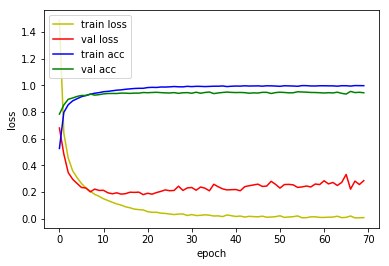

4815/4815 [==============================] - 3s 594us/sample - loss: 0.2486 - acc: 0.9277
Loss: 0.24860892441444804 Accuracy: 0.92772585

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4402 - acc: 0.5341
Epoch 00001: val_loss improved from inf to 0.69611, saving model to model/checkpoint/1D_CNN_kaggle_origin_6_conv_checkpoint/001-0.6961.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.4402 - acc: 0.5342 - val_loss: 0.6961 - val_acc: 0.7703
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6576 - acc: 0.7842
Epoch 00002: val_loss improved from 0.69611 to 0.46086, saving model to model/checkpoint/1D_CNN_kaggle_origin_6_conv_checkpoint/002-0.4609.hdf5
36805/36805 [==============================] - 32s 876us/sample - loss: 0.6577 - acc: 0.7842 - val_loss: 0.4609 - val_acc: 0.8488
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.46

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9927
Epoch 00028: val_loss did not improve from 0.26626
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0226 - acc: 0.9927 - val_loss: 0.3605 - val_acc: 0.9241
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9916
Epoch 00029: val_loss did not improve from 0.26626
36805/36805 [==============================] - 32s 866us/sample - loss: 0.0254 - acc: 0.9916 - val_loss: 0.3294 - val_acc: 0.9299
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9911
Epoch 00030: val_loss did not improve from 0.26626
36805/36805 [==============================] - 32s 868us/sample - loss: 0.0254 - acc: 0.9911 - val_loss: 0.3778 - val_acc: 0.9229
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9906
Epoch 00031: val_loss did not improve from 0.26626
36805/36805 [=====

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9953
Epoch 00058: val_loss did not improve from 0.26626
36805/36805 [==============================] - 32s 865us/sample - loss: 0.0148 - acc: 0.9953 - val_loss: 0.4442 - val_acc: 0.9161

1D_CNN_kaggle_origin_6_conv Model


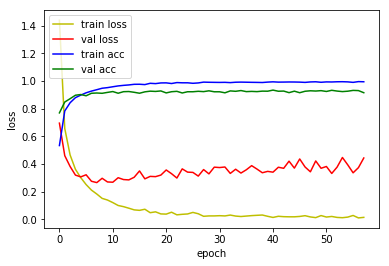

4815/4815 [==============================] - 3s 690us/sample - loss: 0.3447 - acc: 0.8922
Loss: 0.344692622352612 Accuracy: 0.89221185

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4376 - acc: 0.5325
Epoch 00001: val_loss improved from inf to 0.73920, saving model to model/checkpoint/1D_CNN_kaggle_origin_7_conv_checkpoint/001-0.7392.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.4378 - acc: 0.5325 - val_loss: 0.7392 - val_acc: 0.7582
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6987 - acc: 0.7714
Epoch 00002: val_loss improved from 0.73920 to 0.53319, saving model to model/checkpoint/1D_CNN_kaggle_origin_7_conv_checkpoint/002-0.5332.hdf5
36805/36805 [==============================] - 36s 978us/sample - loss: 0.6986 - acc: 0.7714 - val_loss: 0.5332 - val_acc: 0.8283
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4992

36800/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9793
Epoch 00027: val_loss did not improve from 0.32074
36805/36805 [==============================] - 36s 966us/sample - loss: 0.0660 - acc: 0.9792 - val_loss: 0.3521 - val_acc: 0.9252
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9809
Epoch 00028: val_loss did not improve from 0.32074
36805/36805 [==============================] - 36s 966us/sample - loss: 0.0576 - acc: 0.9809 - val_loss: 0.3647 - val_acc: 0.9241
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9843
Epoch 00029: val_loss did not improve from 0.32074
36805/36805 [==============================] - 35s 961us/sample - loss: 0.0459 - acc: 0.9843 - val_loss: 0.3783 - val_acc: 0.9213
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9860
Epoch 00030: val_loss did not improve from 0.32074
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9891
Epoch 00056: val_loss did not improve from 0.31155
36805/36805 [==============================] - 36s 971us/sample - loss: 0.0341 - acc: 0.9890 - val_loss: 0.3757 - val_acc: 0.9255
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9894
Epoch 00057: val_loss did not improve from 0.31155
36805/36805 [==============================] - 36s 986us/sample - loss: 0.0331 - acc: 0.9894 - val_loss: 0.3352 - val_acc: 0.9334
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9943
Epoch 00058: val_loss did not improve from 0.31155
36805/36805 [==============================] - 36s 968us/sample - loss: 0.0173 - acc: 0.9943 - val_loss: 0.4441 - val_acc: 0.9210
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9912
Epoch 00059: val_loss did not improve from 0.31155
36805/36805 [==================

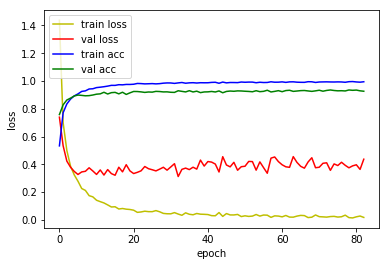

4815/4815 [==============================] - 4s 847us/sample - loss: 0.4602 - acc: 0.9061
Loss: 0.46023374948406887 Accuracy: 0.9061267

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4398 - acc: 0.5307
Epoch 00001: val_loss improved from inf to 0.72925, saving model to model/checkpoint/1D_CNN_kaggle_origin_8_conv_checkpoint/001-0.7292.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.4398 - acc: 0.5307 - val_loss: 0.7292 - val_acc: 0.7587
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7209 - acc: 0.7644
Epoch 00002: val_loss improved from 0.72925 to 0.52556, saving model to model/checkpoint/1D_CNN_kaggle_origin_8_conv_checkpoint/002-0.5256.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.7211 - acc: 0.7644 - val_loss: 0.5256 - val_acc: 0.8258
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5248 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0768 - acc: 0.9745
Epoch 00026: val_loss did not improve from 0.28591
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0769 - acc: 0.9745 - val_loss: 0.3259 - val_acc: 0.9252
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0815 - acc: 0.9726
Epoch 00027: val_loss improved from 0.28591 to 0.28073, saving model to model/checkpoint/1D_CNN_kaggle_origin_8_conv_checkpoint/027-0.2807.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0817 - acc: 0.9725 - val_loss: 0.2807 - val_acc: 0.9283
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0681 - acc: 0.9775
Epoch 00028: val_loss did not improve from 0.28073
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0683 - acc: 0.9775 - val_loss: 0.3103 - val_acc: 0.9278
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9863
Epoch 00055: val_loss did not improve from 0.26296
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0424 - acc: 0.9863 - val_loss: 0.3291 - val_acc: 0.9311
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9902
Epoch 00056: val_loss did not improve from 0.26296
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0308 - acc: 0.9901 - val_loss: 0.3180 - val_acc: 0.9324
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9899
Epoch 00057: val_loss did not improve from 0.26296
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0312 - acc: 0.9899 - val_loss: 0.3893 - val_acc: 0.9238
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9903
Epoch 00058: val_loss did not improve from 0.26296
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9922
Epoch 00085: val_loss did not improve from 0.26296
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0242 - acc: 0.9921 - val_loss: 0.3384 - val_acc: 0.9345
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9893
Epoch 00086: val_loss did not improve from 0.26296
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0364 - acc: 0.9892 - val_loss: 0.2834 - val_acc: 0.9380
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9936
Epoch 00087: val_loss did not improve from 0.26296
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0205 - acc: 0.9936 - val_loss: 0.3286 - val_acc: 0.9408
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9908
Epoch 00088: val_loss did not improve from 0.26296
36805/36805 [===========

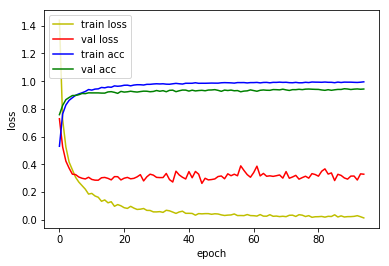

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3738 - acc: 0.9225
Loss: 0.3737751446192386 Accuracy: 0.92253375

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7132 - acc: 0.4508
Epoch 00001: val_loss improved from inf to 1.02559, saving model to model/checkpoint/1D_CNN_kaggle_origin_9_conv_checkpoint/001-1.0256.hdf5
36805/36805 [==============================] - 76s 2ms/sample - loss: 1.7131 - acc: 0.4508 - val_loss: 1.0256 - val_acc: 0.6571
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9538 - acc: 0.6889
Epoch 00002: val_loss improved from 1.02559 to 0.66505, saving model to model/checkpoint/1D_CNN_kaggle_origin_9_conv_checkpoint/002-0.6651.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.9539 - acc: 0.6888 - val_loss: 0.6651 - val_acc: 0.7787
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7087 - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9707
Epoch 00027: val_loss did not improve from 0.27336
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0926 - acc: 0.9707 - val_loss: 0.2918 - val_acc: 0.9245
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0976 - acc: 0.9682
Epoch 00028: val_loss did not improve from 0.27336
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0979 - acc: 0.9681 - val_loss: 0.2793 - val_acc: 0.9238
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9678
Epoch 00029: val_loss improved from 0.27336 to 0.24795, saving model to model/checkpoint/1D_CNN_kaggle_origin_9_conv_checkpoint/029-0.2479.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0973 - acc: 0.9678 - val_loss: 0.2479 - val_acc: 0.9329
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9896
Epoch 00056: val_loss did not improve from 0.24795
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0351 - acc: 0.9895 - val_loss: 0.2835 - val_acc: 0.9378
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9862
Epoch 00057: val_loss did not improve from 0.24795
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0456 - acc: 0.9861 - val_loss: 0.3236 - val_acc: 0.9350
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9844
Epoch 00058: val_loss did not improve from 0.24795
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0512 - acc: 0.9843 - val_loss: 0.3243 - val_acc: 0.9376
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0627 - acc: 0.9802
Epoch 00059: val_loss did not improve from 0.24795
36805/36805 [========================

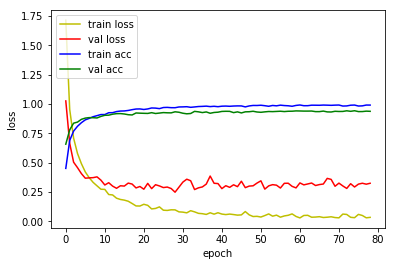

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.3306 - acc: 0.9167
Loss: 0.33056128315650785 Accuracy: 0.9167186



In [10]:
for i in range(5, 10):
    base = '1D_CNN_kaggle_origin'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_kaggle_origin(conv_num=i)
    
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_kaggle_origin'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(5, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_kaggle_origin_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           input_6[0][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 16)           1298716     lambda[0][0]                     
                                                                 lambda_1[

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.3306 - acc: 0.9167
Loss: 0.33056128315650785 Accuracy: 0.9167186
